# README.

This notebook shows how to do some very basic analysis of the measurements.

In [1]:
%matplotlib inline
import dbutils
import pandas as pd
import matplotlib.pyplot as plt
import os

# Where to store outputs.
output_path = "/outputs"
output_path = "."

# Connect to database.
main_connector = dbutils.connect_to_main_database()

/data/anaconda/envs/datathon/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Getting the columns of the tables.

In [2]:
for table in ["measurements", "image_data", "pointcloud_data"]:
    print(table, "\n\t", "\n\t".join(main_connector.get_columns(table)))

measurements 
	 id
	measurement_id
	person_id
	qrcode
	sex
	type
	age_days
	height_cms
	weight_kgs
	muac_cms
	head_circumference_cms
	oedema
	latitude
	longitude
	address
	timestamp
	deleted
	deleted_by
	visible
	created_by
image_data 
	 id
	path
	qrcode
	last_updated
	rejected_by_expert
	had_error
	error_message
	width_px
	height_px
	blur_variance
	has_face
	measurement_id
pointcloud_data 
	 id
	path
	qrcode
	last_updated
	rejected_by_expert
	had_error
	error_message
	number_of_points
	confidence_min
	confidence_avg
	confidence_std
	confidence_max
	centroid_x
	centroid_y
	centroid_z
	stdev_x
	stdev_y
	stdev_z
	measurement_id


# Getting statistical values of measurements.

In [3]:
columns = [
 'age_days',
 'height_cms',
 'weight_kgs',
 'muac_cms',
 'head_circumference_cms',
]

headers = []
rows = []
for column in columns:
    sql_statement = "SELECT MIN({0}), AVG({0}), MAX({0}) FROM measurements WHERE type='manual';".format(column)
    minimum, average, maximum = main_connector.execute(sql_statement, fetch_one=True)
    
    rows.append([column, minimum, average, maximum])
    
headers = ("key", "minimum", "average", "maximum")
df = pd.DataFrame(rows, columns=headers)
df

,key,minimum,average,maximum
0,age_days,0.0000,1090.8873079112122937,17833.0
1,height_cms,5.8000,84.8778,997.9
2,weight_kgs,0.1075,10.8212,714.6
3,muac_cms,0.0000,13.8508,170.0
4,head_circumference_cms,4.4000,45.3271,446.0


In [4]:
max_age_days = 6 * 30
sql_statement = ""
sql_statement += "SELECT COUNT(*) FROM measurements"
sql_statement += " WHERE age_days < {}".format(max_age_days)
sql_statement += " AND type=\'manual\'"
main_connector.execute(sql_statement, fetch_one=True)

(96,)

# Creating pie charts for some columns.

('cgm11whh@gmail.com',) 5274
('cgm13whh@gmail.com',) 2680
('cgm10whh@gmail.com',) 2678
('cgm16whh@gmail.com',) 2548
('cgm2whh@gmail.com',) 2496
('cgm15whh@gmail.com',) 2370
('cgm14whh@gmail.com',) 2134
('cgm9whh@gmail.com',) 2006
('cgm12whh@gmail.com',) 1394
('pushpa.paswan.fhf@gmail.com',) 1270
('cgm1whhinnovation@gmail.com',) 930
('cgm8whh@gmail.com',) 910
('cgm7whh@gmail.com',) 624
('nan',) 134
('mmatiaschek@gmail.com',) 24
('cgm6whh@gmail.com',) 6
(False,) 27472
(True,) 6


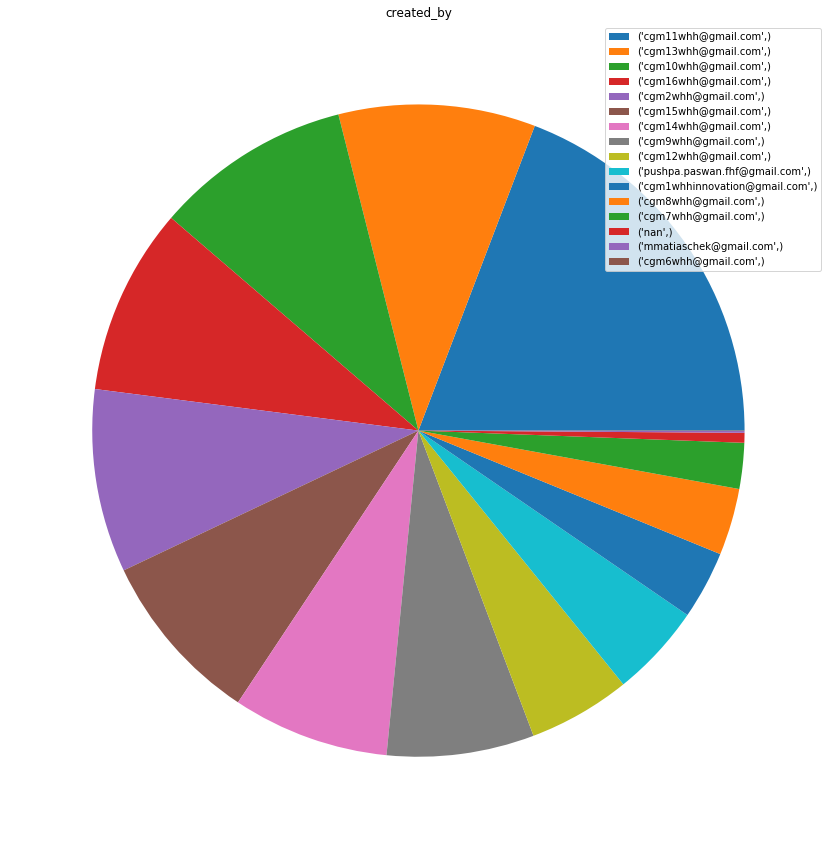

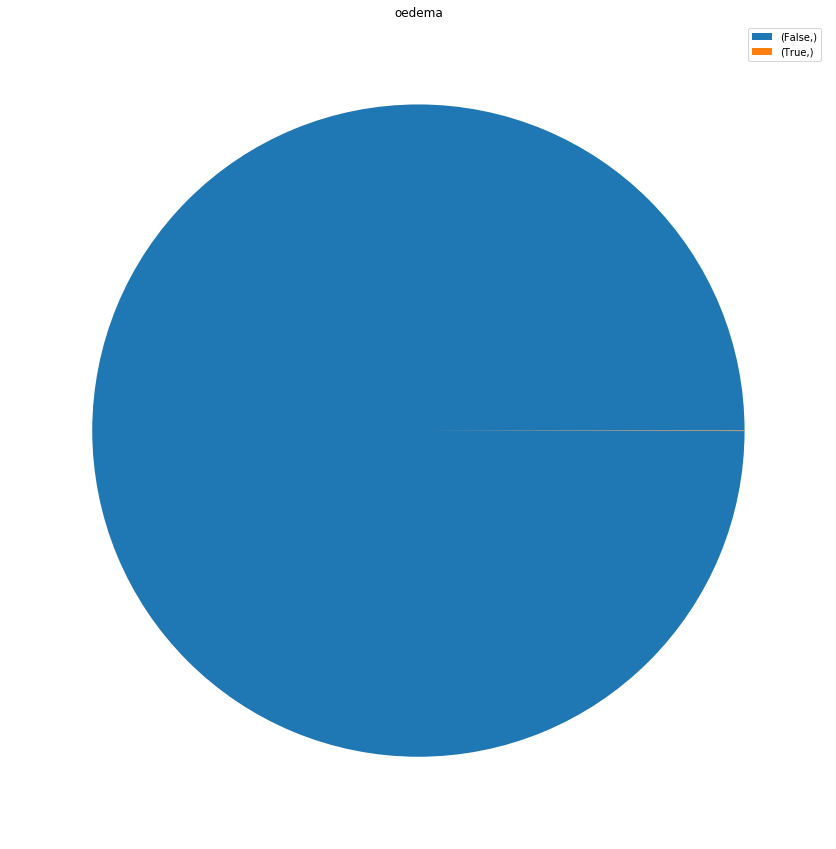

In [5]:
from collections import Counter

def make_pie(key):
    sql_statement = "SELECT {} FROM measurements;".format(key)
    values_list = main_connector.execute(sql_statement, fetch_all=True)

    most_common = Counter(values_list).most_common(10000)

    # TODO percent
    values = []
    keys = []
    for key, value in most_common:
        print(key, value)
        keys.append(str(key))
        values.append(value)
        
    plt.figure(figsize=(15, 15))
    patches, texts = plt.pie(values)
    plt.legend(patches, keys)
    plt.title(df_key)
    plt.savefig(os.path.join(output_path, "pie-{}.png".format(df_key)))

    
df_keys = ["created_by", "oedema"]
for df_key in df_keys:
    make_pie(df_key)

# Render histograms.

[1371, 1104, 617, 707, 608, 1586, 1241, 1288, 345, 1241]


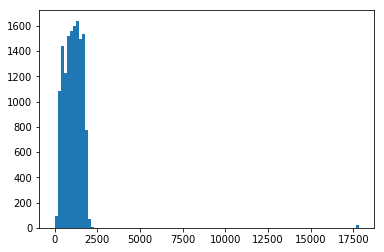

[90.5, 85.4, 76.3, 74.0, 71.0, 93.0, 76.9, 94.8, 68.3, 76.9]


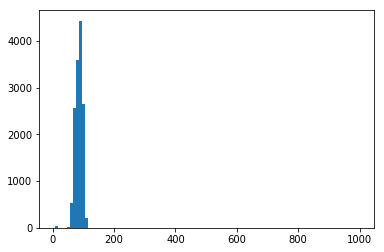

[10.7, 9.75, 8.2, 7.3, 7.65, 11.4, 76.9, 11.0, 8.0, 7.6]


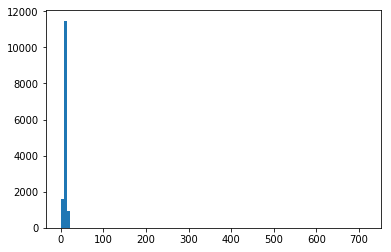

[13.5, 14.1, 13.5, 11.6, 12.6, 14.0, 12.3, 13.2, 13.1, 12.3]


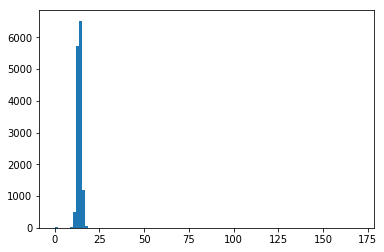

In [6]:
def render_histogram(key, values, bins):
    hist = plt.hist(values, bins=bins)
    plt.savefig("histogram-{}.png".format(key))
    plt.show()
    
render_parameters = []
render_parameters.append(("age_days", 100))
render_parameters.append(("height_cms", 100))
render_parameters.append(("weight_kgs", 100))
render_parameters.append(("muac_cms", 100))
for key, bins in render_parameters:
    sql_statement = "SELECT {} FROM measurements WHERE type='manual'".format(key)
    results = main_connector.execute(sql_statement, fetch_all=True)
    values = [result[0] for result in results]
    print(values[0:10])
    render_histogram(key, values, bins)

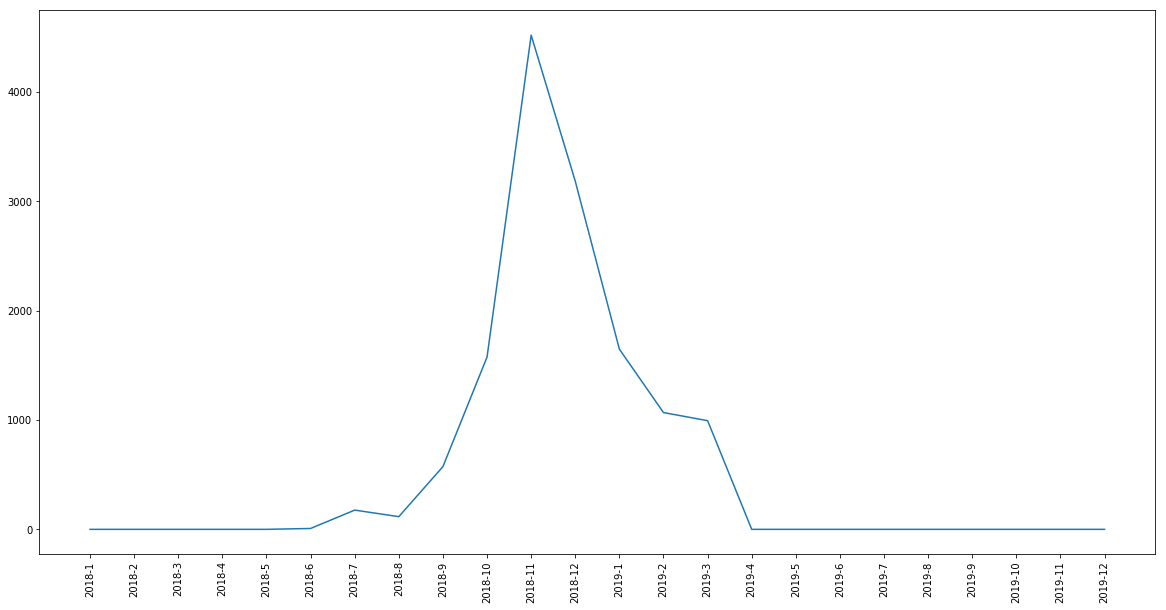

In [7]:
from datetime import date
from time import mktime
import calendar

plot_values = []
plot_labels = []
for year in [2018, 2019]:
    for month in range(1, 13):
        
        # Getting the start.
        start_day = 1
        start_date = date(year, month, start_day)
        start_timestamp = str(1000 * int(mktime(start_date.timetuple())))
        
        # Getting the end.
        _, end_day = calendar.monthrange(year, month)
        end_date = date(year, month, end_day)
        end_timestamp = str(1000 * int(mktime(end_date.timetuple())))

        # Getting the number of entries from the database.
        sql_statement = ""
        sql_statement += "SELECT COUNT(*) FROM measurements"
        sql_statement += " WHERE type='manual'"
        sql_statement += " AND timestamp >= {}".format(start_timestamp)
        sql_statement += " AND timestamp <= {}".format(end_timestamp)
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        
        # Prepare the plot.
        plot_values.append(number_of_entries)
        plot_labels.append("{}-{}".format(year, month))
        
# Plot the plot.
plt.figure(figsize=(20,10))
plt.plot(plot_values)
plt.xticks(range(len(plot_labels)), plot_labels, rotation='vertical')
plt.show()
plt.close()